In [10]:
import torch
from torch import nn
from torch.optim import Adam
from model import load_models, Encoder, AttentionDecoder, EMBEDDING_SIZE
import random
from prepared import load_voc, batch2train_data, input_var
import matplotlib.pyplot as plt

In [11]:
data, Vocabulary = load_voc()

In [12]:
device = "cuda:0"
batch_size = 2

In [13]:
Vocabulary.num_words

35691

In [14]:
embedding = nn.Embedding(2**16, EMBEDDING_SIZE).to(device)
encoder = Encoder(embedding).to(device)
decoder = AttentionDecoder(embedding).to(device)

In [15]:
# encoder, decoder, embedding = load_models()

encoder_optim = Adam(encoder.parameters(), lr=1e-4)
decoder_optim = Adam(decoder.parameters(), lr=5e-4)

encoder.epochs

0

In [16]:
def calculate_loss(inp, target, mask):

    loss = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = loss.masked_select(mask).mean()
    loss = loss.to(device)

    return loss

In [17]:
def train(epochs):
    # для вывода графика
    history = []
    short_mem = []

    for _ in range(epochs):
        # всё стандартно
        encoder_optim.zero_grad()
        decoder_optim.zero_grad()

        inp, lenghts, target, mask, max_target_len = batch2train_data([random.choice(data) \
                                                                       for _ in range(batch_size)])

        inp = inp.to(device)
        lenghts = lenghts.to(device)
        target = target.to(device)
        mask = mask.to(device)
        # провожу через енкодинг
        encoder_out, encoder_hidden = encoder(inp, lenghts)
        # начальное значение для работы декодера
        decoder_input = torch.ones(batch_size).long().to(device).unsqueeze(0)

        loss = 0

        decoder_hidden = encoder_hidden[:2]

        for i in range(max_target_len):
            decoder_out, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_out)

            decoder_input = torch.LongTensor([[decoder_out.topk(1)[1][x][0] for\
                                               x in range(batch_size)]]).to(device)

            loss += calculate_loss(decoder_out, target[i], mask[i])

        short_mem.append(loss)

        if not encoder.epochs % 1000:
            print(f'{encoder.epochs}  {loss}')
            history.append(torch.tensor(short_mem).mean())
            short_mem = []

        loss.backward()

        encoder_optim.step()
        decoder_optim.step()

        encoder.epochs += 1

        # save model

        if not encoder.epochs % 1000:

            torch.save(encoder, f"models/encoder{encoder.epochs}")
            torch.save(decoder, f"models/decoder{encoder.epochs}")
            torch.save(embedding, f"models/embedding{encoder.epochs}")

    return history

In [18]:
%%time
history = train(10000)

0  233.4412384033203
250  443.6858825683594
500  108.73165130615234
750  920.1856079101562
1000  31.838638305664062
1250  59.359004974365234
1500  117.36520385742188
1750  212.2256622314453
2000  283.78436279296875
2250  85.50106048583984
2500  670.3023681640625
2750  15.861475944519043
3000  821.947265625
3250  79.17782592773438
3500  83.49701690673828
3750  160.59173583984375
4000  33.2389030456543
4250  429.17486572265625
4500  36.620609283447266
4750  236.41908264160156
5000  88.90542602539062
5250  388.63531494140625
5500  196.314697265625
5750  171.79110717773438
6000  155.70579528808594
6250  15.127235412597656
6500  142.1136016845703
6750  90.85939025878906
7000  459.95556640625
7250  170.26571655273438
7500  73.56256103515625
7750  68.0396728515625
8000  647.3107299804688
8250  89.46467590332031
8500  63.553810119628906
8750  277.882080078125
9000  350.80841064453125
9250  206.03199768066406
9500  65.32363891601562
9750  57.47719955444336
CPU times: user 25min 16s, sys: 10.9 s

In [19]:
encoder.epochs

10000

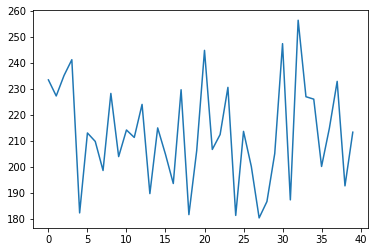

In [21]:
plt.plot(history)

In [47]:
def search(sequence):

    inp, lengths = input_var([sequence])

    inp = inp.to(device)
    lengths = lengths.to(device)

    encoder_out, encoder_hidden = encoder(inp, lengths)
    decoder_input = torch.ones(1, 1, device=device, dtype=torch.long)

    all_tokens = torch.zeros([0], device=device, dtype=torch.long)
    all_scores = torch.zeros([0], device=device)

    decoder_hidden = encoder_hidden[:2]

    for _ in range(25):
        decoder_out, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_out)

        decoder_scores, decoder_input = torch.max(decoder_out, dim=1)

        all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
        all_scores = torch.cat((all_scores, decoder_scores), dim=0)

        decoder_input = torch.unsqueeze(decoder_input, 0)

    return all_tokens, all_scores

In [48]:
inp, lengths = search('кивнул и мои глаза остановились')

In [52]:
inp

tensor([80, 80, 80, 80, 33, 33, 33, 80, 33, 33,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4], device='cuda:0')

In [50]:
lengths


tensor([0.0425, 0.0411, 0.0449, 0.0334, 0.0386, 0.0382, 0.0372, 0.0462, 0.0422,
        0.0414, 0.0517, 0.0515, 0.0475, 0.0438, 0.0422, 0.0359, 0.0328, 0.0324,
        0.0299, 0.0295, 0.0283, 0.0304, 0.0320, 0.0311, 0.0318],
       device='cuda:0', grad_fn=<CatBackward>)

In [27]:
encoder_out, encoder_hidden = encoder(inp, lengths)

In [28]:
encoder_out

tensor([[[-2.1320e-01,  4.3730e-01, -4.2970e-01, -3.8275e-01, -1.2079e-01,
          -1.2245e-01,  2.1373e-02,  2.7181e-01,  1.8780e-01, -1.8463e-01,
           4.9407e-01,  1.9684e-01, -3.4262e-02,  6.5111e-02, -3.7022e-01,
           2.1757e-01, -2.4075e-01, -1.5265e-02, -3.9065e-01, -3.0115e-03,
           8.3825e-02,  1.1649e-01,  3.5540e-01, -2.5361e-01, -2.5436e-01,
          -8.3635e-02, -7.9861e-02,  4.0004e-02, -1.6635e-01,  1.2981e-02,
           2.9770e-01, -2.9772e-01, -4.6229e-01, -1.3290e-01,  2.4256e-01,
           2.8078e-01,  7.3464e-02, -1.2735e-01,  2.0432e-02,  1.3913e-01,
          -2.1085e-01, -2.3671e-01,  4.6625e-02, -2.4605e-01,  9.7775e-02,
           1.7090e-01,  1.5209e-01,  9.8287e-02, -2.8571e-01,  3.4850e-01,
          -2.1867e-01, -3.4801e-01,  5.8992e-02, -1.3820e-01, -3.3405e-01,
           1.0672e-02, -2.7253e-01,  4.8317e-01,  1.1852e-01,  5.9137e-02,
           4.4468e-02, -2.0317e-01,  1.8798e-01,  2.3542e-02,  1.4300e-01,
           1.9950e-01,  4

In [29]:
encoder_hidden

tensor([[[ 0.4472, -0.4278, -0.0179,  0.1878, -0.4146, -0.0275,  0.0506,
           0.3924,  0.0735, -0.1753, -0.2786,  0.2217, -0.2036, -0.2611,
           0.0944, -0.4367, -0.2521, -0.0015, -0.0211, -0.3091,  0.1354,
          -0.1406,  0.3529,  0.4567,  0.5324, -0.0658,  0.3963, -0.2500,
          -0.6350,  0.2516,  0.3516, -0.0025,  0.4484,  0.1326,  0.3176,
           0.2969,  0.0836, -0.0576, -0.5152, -0.1531,  0.0371,  0.3242,
           0.1001, -0.2536, -0.3035, -0.0056,  0.6130, -0.3710,  0.0088,
           0.2288, -0.5331,  0.1660, -0.0313,  0.2441,  0.3418, -0.3586,
           0.2874,  0.2417,  0.1622,  0.2186, -0.3818, -0.0456, -0.0381,
          -0.2254, -0.3671, -0.2389, -0.1530,  0.2087, -0.4251,  0.0183,
          -0.6031, -0.0735, -0.2858, -0.0650, -0.2500, -0.1841, -0.1936,
           0.2211, -0.2007, -0.1240, -0.0835,  0.0336, -0.0457,  0.2369,
          -0.3466, -0.1847, -0.1899,  0.3976,  0.0536, -0.2187,  0.0436,
          -0.1409,  0.4058, -0.4165, -0.0179,  0.22

In [34]:
decoder_input = torch.ones(1, 1, device=device, dtype=torch.long)

In [32]:
torch.ones(1, 1, device=device, dtype=torch.long)

tensor([[1]], device='cuda:0')

In [36]:
decoder_out, decoder_hidden = decoder(decoder_input, encoder_hidden[:2], encoder_out)

In [39]:
scor, inp = torch.max(decoder_out, dim=1)

In [40]:
scor

tensor([0.0470], device='cuda:0', grad_fn=<MaxBackward0>)

In [41]:
inp

tensor([80], device='cuda:0')

In [42]:
torch.zeros([0], device=device, dtype=torch.long)

tensor([], device='cuda:0', dtype=torch.int64)